In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from pandas.plotting import scatter_matrix
import osqp
from scipy import sparse
from sklearn.covariance import LedoitWolf
from sklearn.preprocessing import StandardScaler

In [2]:
a = np.array([[1,2,3,4], [1,1,1,1], [4,3,66,7], [2,3,4,4]])

In [3]:
scaler = StandardScaler()
scaler.fit(a)

c:\users\uporabnik\anaconda2\envs\mypython3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
a_scaled = scaler.transform(a)

c:\users\uporabnik\anaconda2\envs\mypython3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
a_scaled[:,0].std()

1.0

In [3]:
def pf_optim(risk_aversion, mu, sigma):

    # Setup workspace
    """
    setup(self, P=None, q=None, A=None, l=None, u=None, **settings):
            Setup OSQP solver problem of the form
            minimize     1/2 x' * P * x + q' * x
            subject to   l <= A * x <= u
    """
    k = len(mu)                         # dimension of the problem

    problem = osqp.OSQP()
    A = np.concatenate((np.ones((1, k)), np.eye(k)), axis=0)
    sA = sparse.csr_matrix(A)
    l = np.hstack([1, np.zeros(k)])
    u = np.ones(k + 1)
    sCov = sparse.csr_matrix(risk_aversion*sigma)

    problem.setup(sCov, -mu, sA, l, u)

    # Solve problem
    res = problem.solve()

    return res.x

In [4]:
numdays = 365*10
base = datetime.date.today()
date_list = list(reversed([base - datetime.timedelta(days=x) for x in range(0, numdays)]))

In [5]:
dir = 'stocks/'

df0 = pd.DataFrame(index = pd.DatetimeIndex(date_list))
df0.index 
for file in os.listdir(dir):
    filename = os.fsdecode(file)
    df = pd.read_csv(dir + filename)
    #print(len(df))
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True, drop=True)
    df = df[['Adj Close']]
    df.columns = [filename[:-4]]
    #here choice of how parameter is crucial!! 
    df0=pd.merge(df0,df, how='inner', left_index=True, right_index=True)

In [7]:
df0.head()

,AAPL,BTC-USD,ETC-USD,ETH-USD,LTC-USD,TSLA,XEM-USD,XRP-USD
2016-07-26,92.355492,3.96,1.60,13.05,3.96,229.509995,0.006637,0.005952
2016-07-27,98.355217,3.96,1.68,12.87,3.96,228.490005,0.006633,0.006008
2016-07-28,99.683159,4.05,1.64,12.87,4.05,230.610001,0.006535,0.006200
2016-07-29,99.558975,4.07,1.57,12.57,4.07,234.789993,0.006705,0.006200
2016-08-01,101.316849,3.50,2.60,8.30,3.50,230.009995,0.004652,0.005695


In [8]:
df0.describe()

,AAPL,BTC-USD,ETC-USD,ETH-USD,LTC-USD,TSLA,XEM-USD,XRP-USD
count,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000
mean,156.521889,62.082249,11.141128,277.537750,62.082249,296.685198,0.181696,0.342588
std,32.656007,65.523764,9.119896,273.436116,65.523764,52.246430,0.245765,0.381380
min,92.355492,3.490000,0.743500,6.690000,3.490000,181.449997,0.003221,0.005390
25%,136.414425,4.412500,2.387500,42.802499,4.412500,261.927513,0.013970,0.009125
50%,156.438637,46.335001,10.950000,214.675003,46.335001,308.724990,0.105550,0.269250
75%,174.472504,78.990000,16.412500,415.859993,78.990000,337.935013,0.225850,0.470525
max,230.275482,357.510010,38.930000,1289.239990,357.510010,385.000000,1.770000,2.730000


In [49]:
df0.shape

(658, 8)

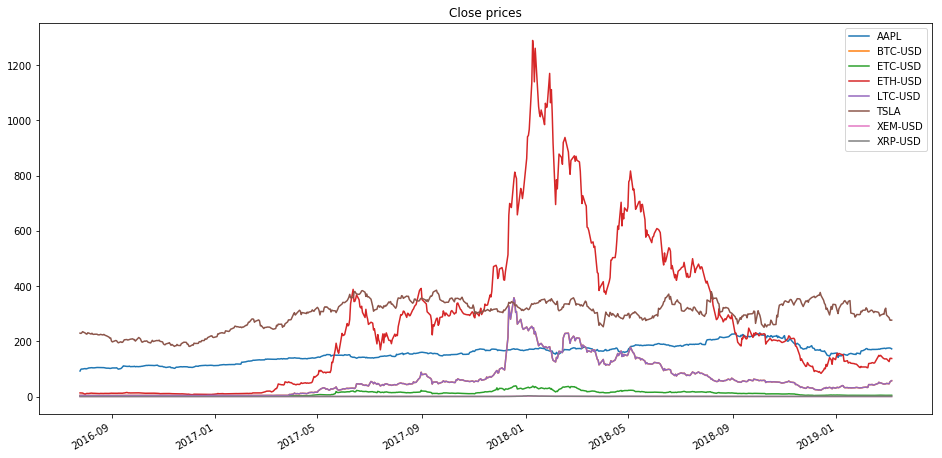

In [9]:
df0.plot(title='Close prices', figsize=(16,8))
plt.legend()

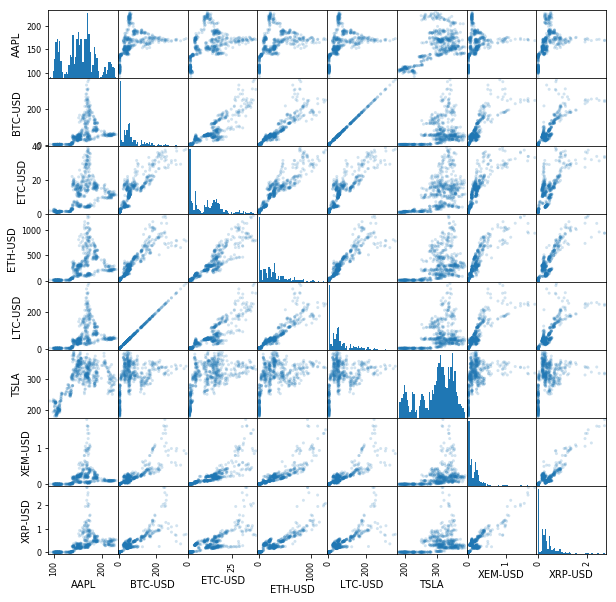

In [7]:
scatter_matrix(df0, alpha=0.2, figsize=(10, 10), hist_kwds={'bins':50});

In [10]:
#df0_returns = df0/df0.shift(1) - 1
df0_returns = df0.pct_change()

In [11]:
df0_returns.head()

,AAPL,BTC-USD,ETC-USD,ETH-USD,LTC-USD,TSLA,XEM-USD,XRP-USD
2016-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-27,0.064963,0.000000,0.050000,-0.013793,0.000000,-0.004444,-0.000603,0.009409
2016-07-28,0.013501,0.022727,-0.023810,0.000000,0.022727,0.009278,-0.014775,0.031957
2016-07-29,-0.001246,0.004938,-0.042683,-0.023310,0.004938,0.018126,0.026014,0.000000
2016-08-01,0.017657,-0.140049,0.656051,-0.339698,-0.140049,-0.020359,-0.306189,-0.081452


## 1) TRAIN/TEST split (wrong!!)

In [10]:
#split returns table to train and test datasets
split = 0.8
df0_returns_train, df0_returns_test = df0_returns.iloc[:int(len(df0_returns)*split)], \
                                                    df0_returns.iloc[int(len(df0_returns)*split):]

In [11]:
#mean vector of returns
df0_returns_train.mean()

AAPL       0.001685
BTC-USD    0.008472
ETC-USD    0.007902
ETH-USD    0.008850
LTC-USD    0.008472
TSLA       0.000970
XEM-USD    0.011271
XRP-USD    0.013004
dtype: float64

In [12]:
mu = np.array(df0_returns_train.mean())

In [13]:
cov_matrix = df0_returns_train.cov()

In [14]:
#covariance matrix of returns
cov_matrix

,AAPL,BTC-USD,ETC-USD,ETH-USD,LTC-USD,TSLA,XEM-USD,XRP-USD
AAPL,0.000160,0.000045,0.000052,0.000004,0.000045,0.000092,0.000013,0.000106
BTC-USD,0.000045,0.007707,0.003305,0.003289,0.007707,0.000061,0.004002,0.003329
ETC-USD,0.000052,0.003305,0.008730,0.003720,0.003305,-0.000042,0.003661,0.002134
ETH-USD,0.000004,0.003289,0.003720,0.006375,0.003289,0.000030,0.003726,0.002344
LTC-USD,0.000045,0.007707,0.003305,0.003289,0.007707,0.000061,0.004002,0.003329
TSLA,0.000092,0.000061,-0.000042,0.000030,0.000061,0.000646,-0.000134,-0.000011
XEM-USD,0.000013,0.004002,0.003661,0.003726,0.004002,-0.000134,0.016028,0.004492
XRP-USD,0.000106,0.003329,0.002134,0.002344,0.003329,-0.000011,0.004492,0.012701


In [15]:
sigma = np.array(cov_matrix)

In [17]:
cov_LW = LedoitWolf().fit(df0_returns_train.iloc[1:])

In [21]:
cov_LW.covariance_

array([[ 9.68299615e-04,  4.03036452e-05,  4.61860457e-05,
         3.49917228e-06,  4.03036452e-05,  8.17846279e-05,
         1.14990756e-05,  9.42220214e-05],
       [ 4.03036452e-05,  7.67025128e-03,  2.93470360e-03,
         2.92051450e-03,  6.84371800e-03,  5.44653152e-05,
         3.55336922e-03,  2.95650166e-03],
       [ 4.61860457e-05,  2.93470360e-03,  8.57910597e-03,
         3.30370927e-03,  2.93470360e-03, -3.69884590e-05,
         3.25064117e-03,  1.89524611e-03],
       [ 3.49917228e-06,  2.92051450e-03,  3.30370927e-03,
         6.48790264e-03,  2.92051450e-03,  2.65879216e-05,
         3.30881383e-03,  2.08168019e-03],
       [ 4.03036452e-05,  6.84371800e-03,  2.93470360e-03,
         2.92051450e-03,  7.67025128e-03,  5.44653152e-05,
         3.55336922e-03,  2.95650166e-03],
       [ 8.17846279e-05,  5.44653152e-05, -3.69884590e-05,
         2.65879216e-05,  5.44653152e-05,  1.40053933e-03,
        -1.18701261e-04, -9.53717105e-06],
       [ 1.14990756e-05,  3.553369

In [102]:
theta = pf_optim(0.9, mu, cov_matrix, ) #QUESTION: reasonable value for risk aversion??

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 8, constraints m = 9
          nnz(P) + nnz(A) = 52
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off

objective    pri res    dua res    rho        time
   1  -8.0100e-03   1.42e+00   1.30e+00   1.00e-01   1.55e-04s
  50  -8.5234e-03   6.27e-05   2.13e-08   1.00e-01   3.69e-04s

status:               solved
number of iterations: 50
optimal objective: 

c:\users\uporabnik\anaconda2\envs\mypython3\lib\site-packages\osqp\interface.py:109: UserWarning: Converting sparse P to a CSC (compressed sparse column) matrix. (It may take a while...)
  "(compressed sparse column) matrix. (It may take a while...)")
c:\users\uporabnik\anaconda2\envs\mypython3\lib\site-packages\osqp\interface.py:113: UserWarning: Converting sparse A to a CSC (compressed sparse column) matrix. (It may take a while...)
  "(compressed sparse column) matrix. (It may take a while...)")


In [120]:
theta

array([-5.23061093e-05, -6.26962391e-05, -4.29637309e-05,  2.76581349e-01,
       -6.26962391e-05, -5.42979048e-05,  1.84007286e-01,  5.39686378e-01])

In [104]:
#accounting for some negative values in the portfolio 
#theta = np.where(theta < 0, 0, theta) 

#QUESTION: do we allow negative values in the portfolio? does that simply mean that we are on the short side of the trade?

In [105]:
sum(theta)

1.000000053209849

In [106]:
(df0_returns_test*theta).head()

,AAPL,BTC-USD,ETC-USD,ETH-USD,LTC-USD,TSLA,XEM-USD,XRP-USD
2018-08-27,-4.307255e-07,-0.000006,-2.402126e-06,0.017927,-0.000006,5.971084e-07,0.017865,0.038749
2018-08-28,-4.224025e-07,0.000002,6.824798e-07,-0.006438,0.000002,1.260211e-06,-0.006514,-0.009385
2018-08-29,-7.808983e-07,0.000001,5.614016e-07,-0.004331,0.000001,1.192648e-06,-0.005402,-0.015500
2018-08-30,-4.808879e-07,-0.000002,3.346085e-07,-0.002424,-0.000002,3.311202e-07,-0.000696,0.000000
2018-08-31,-6.043456e-07,-0.000004,-1.483834e-06,0.013453,-0.000004,2.668756e-07,0.010824,0.019344


In [107]:
#pnl = profit and loss
pnl = (df0_returns_test*theta).sum(axis=1)

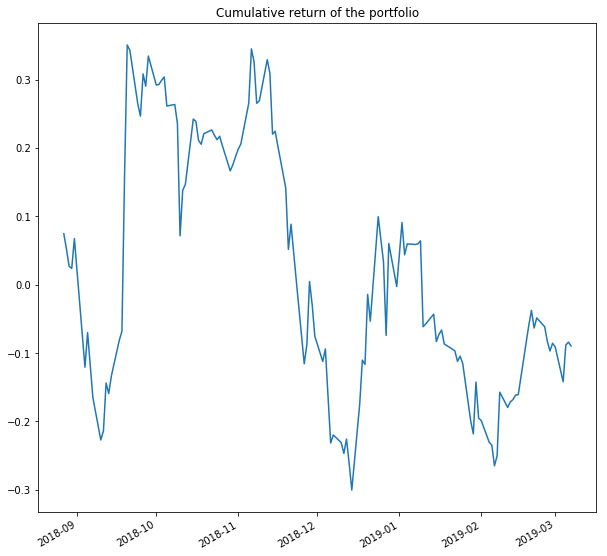

In [110]:
pnl.cumsum().plot(title = 'Cumulative return of the portfolio', figsize=(10,10));

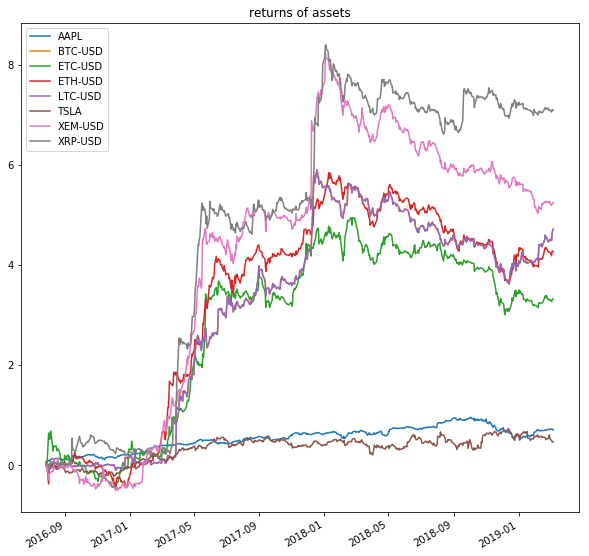

In [111]:
df0_returns.cumsum().plot(title='returns of assets', figsize=(10,10));

In [24]:
theta_LW = pf_optim(0.9, mu, cov_LW.covariance_)

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 8, constraints m = 9
          nnz(P) + nnz(A) = 52
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off

objective    pri res    dua res    rho        time
   1  -7.9183e-03   1.38e+00   1.30e+00   1.00e-01   9.91e-04s
  50  -8.7171e-03   7.13e-05   2.22e-08   1.00e-01   2.99e-03s

status:               solved
number of iterations: 50
optimal objective: 

c:\users\uporabnik\anaconda2\envs\mypython3\lib\site-packages\osqp\interface.py:109: UserWarning: Converting sparse P to a CSC (compressed sparse column) matrix. (It may take a while...)
  "(compressed sparse column) matrix. (It may take a while...)")
c:\users\uporabnik\anaconda2\envs\mypython3\lib\site-packages\osqp\interface.py:113: UserWarning: Converting sparse A to a CSC (compressed sparse column) matrix. (It may take a while...)
  "(compressed sparse column) matrix. (It may take a while...)")


In [25]:
theta_LW

array([-6.23512387e-05, -7.12994714e-05, -5.38754678e-05,  2.42438315e-01,
       -7.12994714e-05, -6.45243984e-05,  2.04737377e-01,  5.53147718e-01])

In [26]:
sum(theta_LW)

1.0000000602091441

In [27]:
#pnl = profit and loss
pnl_LW = (df0_returns_test*theta_LW).sum(axis=1)

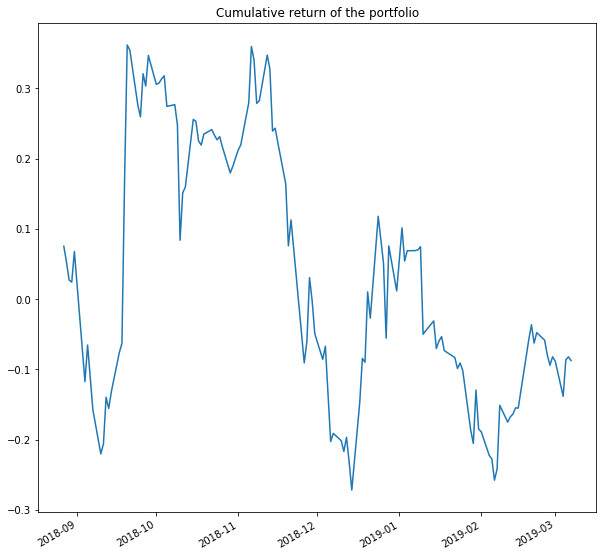

In [29]:
pnl_LW.cumsum().plot(title = 'Cumulative return of the portfolio', figsize=(10,10));

## 2) Rolling, windows

In [12]:
returns = df0_returns.rolling(30).mean().dropna()
covariances = df0_returns.rolling(30).cov().dropna()

In [13]:
returns.head()

,AAPL,BTC-USD,ETC-USD,ETH-USD,LTC-USD,TSLA,XEM-USD,XRP-USD
2016-09-07,0.004083,0.000693,0.006502,-0.000531,0.000693,-0.004183,-0.001735,0.000576
2016-09-08,0.001044,0.000609,0.003474,0.000895,0.000609,-0.004753,0.002012,0.000767
2016-09-09,-0.000161,-0.000148,0.004505,0.001833,-0.000148,-0.005551,0.000461,-0.000923
2016-09-12,0.000627,-0.001575,0.002876,0.002250,-0.001575,-0.005498,-0.000706,-0.000923
2016-09-13,0.000832,0.003180,-0.018734,0.013714,0.003180,-0.005198,0.008544,0.002587


In [41]:
weights = pd.DataFrame(columns=returns.columns, index=returns.index)
portfolios = []
for i, date in enumerate(returns.index):
    #recalibrate the portfolio every month
    if i % 30 == 0: 
        sigma = np.array(covariances.loc[date])
        mu = np.array(returns.loc[date])
        theta = pf_optim(0.9, mu, sigma)
        portfolios.append((date, theta))
    weights.loc[date] = theta 

c:\users\uporabnik\anaconda2\envs\mypython3\lib\site-packages\osqp\interface.py:109: UserWarning: Converting sparse P to a CSC (compressed sparse column) matrix. (It may take a while...)
  "(compressed sparse column) matrix. (It may take a while...)")
c:\users\uporabnik\anaconda2\envs\mypython3\lib\site-packages\osqp\interface.py:113: UserWarning: Converting sparse A to a CSC (compressed sparse column) matrix. (It may take a while...)
  "(compressed sparse column) matrix. (It may take a while...)")


-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 8, constraints m = 9
          nnz(P) + nnz(A) = 52
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off

objective    pri res    dua res    rho        time
   1  -7.3629e-02   1.29e+01   4.21e-01   1.00e-01   2.01e-04s
  75  -4.1194e-03   2.15e-05   4.27e-07   7.75e-01   1.65e-04s

status:               solved
number of iterations: 75
optimal objective: 

-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 8, constraints m = 9
          nnz(P) + nnz(A) = 52
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off

objective    pri res    dua res    rho        time
   1  -1.0420e-01   4.92e+00   1.22e+00   1.00e-01   1.58e-04s
  50  -6.7454e-03   2.99e-07   5.34e-10   6.97e-01   8.88e-05s

status:               solved
number of iterations: 50
optimal objective: 

In [42]:
weights.head()

,AAPL,BTC-USD,ETC-USD,ETH-USD,LTC-USD,TSLA,XEM-USD,XRP-USD
2016-09-07,0.890296,8.38482e-06,0.109669,-1.16096e-05,8.38482e-06,1.76802e-05,-9.52661e-06,2.15395e-05
2016-09-08,0.890296,8.38482e-06,0.109669,-1.16096e-05,8.38482e-06,1.76802e-05,-9.52661e-06,2.15395e-05
2016-09-09,0.890296,8.38482e-06,0.109669,-1.16096e-05,8.38482e-06,1.76802e-05,-9.52661e-06,2.15395e-05
2016-09-12,0.890296,8.38482e-06,0.109669,-1.16096e-05,8.38482e-06,1.76802e-05,-9.52661e-06,2.15395e-05
2016-09-13,0.890296,8.38482e-06,0.109669,-1.16096e-05,8.38482e-06,1.76802e-05,-9.52661e-06,2.15395e-05


In [43]:
pnl2 = (df0_returns*weights.shift(1)).dropna().sum(axis=1)

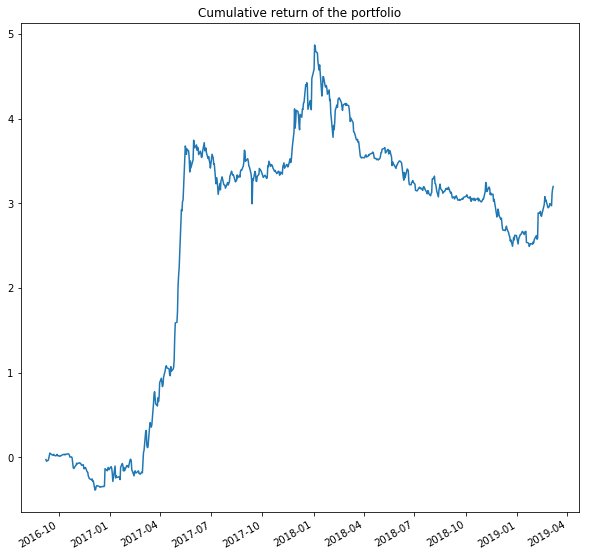

In [44]:
pnl2.cumsum().plot(title = 'Cumulative return of the portfolio', figsize=(10,10));

In [48]:
df0.corr()

,AAPL,BTC-USD,ETC-USD,ETH-USD,LTC-USD,TSLA,XEM-USD,XRP-USD
AAPL,1.000000,0.474950,0.504311,0.493276,0.474950,0.598386,0.292643,0.508947
BTC-USD,0.474950,1.000000,0.888030,0.921608,1.000000,0.432289,0.844616,0.843802
ETC-USD,0.504311,0.888030,1.000000,0.923900,0.888030,0.601808,0.823182,0.769721
ETH-USD,0.493276,0.921608,0.923900,1.000000,0.921608,0.514436,0.867357,0.871642
LTC-USD,0.474950,1.000000,0.888030,0.921608,1.000000,0.432289,0.844616,0.843802
TSLA,0.598386,0.432289,0.601808,0.514436,0.432289,1.000000,0.416276,0.425965
XEM-USD,0.292643,0.844616,0.823182,0.867357,0.844616,0.416276,1.000000,0.894468
XRP-USD,0.508947,0.843802,0.769721,0.871642,0.843802,0.425965,0.894468,1.000000
